# CIFAR10 분류를 위한 VGGNet 모델 학습

VGG-16 : 13 convolutional layers, 3 fully conncected layers

Filter size = 3x3 Stride = 1 Padding = 1

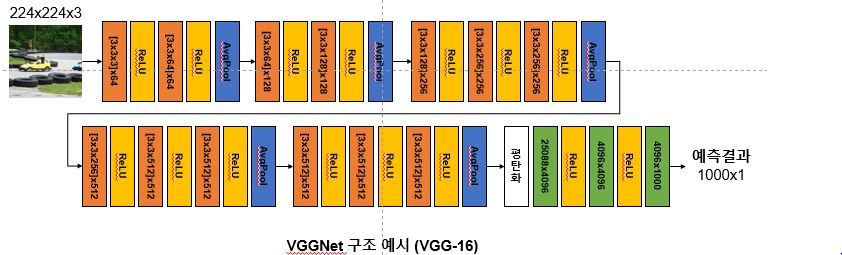

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
datasetPath = "./drive/MyDrive/dataset/"
parameterPath = "./drive/MyDrive/parameters"

Mounted at /content/drive


### 패키지 선언

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transform
from torch.utils.data import DataLoader
import numpy as np

### 데이터셋 선언

In [ ]:
# Training dataset 다운로드
cifar10_train = dataset.CIFAR10(root = datasetPath,
                            train = True, # train 데이터셋이면 true
                            transform = transform.ToTensor(),
                            download = True)
# Testing dataset 다운로드
cifar10_test = dataset.CIFAR10(root = datasetPath,
                           train = False, # train 데이터셋이 아닌(test 데이터셋이면) false
                           transform = transform.ToTensor(),
                           download = True)

Files already downloaded and verified
Files already downloaded and verified


50000
torch.Size([3, 32, 32])
6


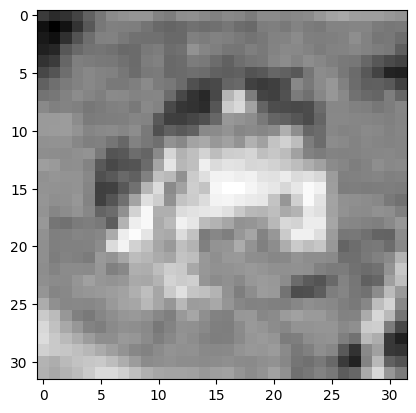

In [ ]:
# CIFAR10 데이터셋 형상 확인
import matplotlib.pyplot as plt
print(len(cifar10_train)) #train 데이터셋 개수 확인 : 6만개

first_data = cifar10_train[0]
print(first_data[0].shape)  # 첫번째 data의 형상 확인 - 데이터 이미지 (3x32x32pixels)
print(first_data[1])        # 첫번째 data의 정답 확인 - 데이터 값(숫자) (5)

plt.imshow(first_data[0][0,:,:], cmap = 'gray')
plt.show()

## CNN 모델 정의

**Conv2d : Convolution layer**

torch.nn.Conv2d(***in_channels***, ***out_channels***, ***kernel_size***, **stride=1**, **padding=0**, dilation=1,groups=1,bias=True,padding_mode='zeros',device=None,dtype=None)

**Linear : Fully connected layer**

torch.nn.Linear(***in_features***, ***out_features***, bias=True,device=None, dype=None)

**ReLU : Activation Function**

torch.nn.ReLU(inplace=False)

**AvgPool2d : Pooling layer**

torch.nn.AvgPool2d(**kernel_size**, **stride=None**, padding=0, dilation=1 return_indices=False,ceil_mode=False)

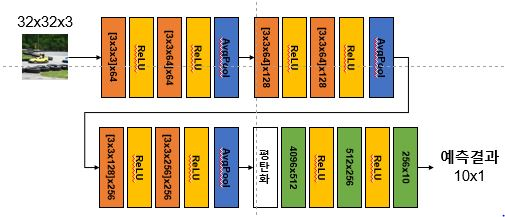

32x32x**3** -conv1[5x5x**1**]x**6**->  24x24x**6**



In [ ]:
class VGG (nn.Module):
    def __init__(self): # 신경망 구성요소 정의
        super(VGG, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=64, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(in_channels=64,out_channels=128, kernel_size=3,  padding=1)
        self.conv5 = nn.Conv2d(in_channels=128,out_channels=256, kernel_size=3,  padding=1)
        self.conv6 = nn.Conv2d(in_channels=256,out_channels=256, kernel_size=3,  padding=1)

        self.fc1 = nn.Linear(in_features=4096, out_features=2000)
        self.fc2 = nn.Linear(in_features=2000, out_features=1000)
        self.fc3 = nn.Linear(in_features=1000, out_features=10)
        self.relu = nn.ReLU()
        self.avgPool2d = nn.AvgPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm1d(2000)
        self.bn2 = nn.BatchNorm1d(1000)

    def forward(self, x): # 신경망 동작 순서 (입출력 구조) 정의
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        out = self.avgPool2d(out)

        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = self.avgPool2d(out)

        out = self.relu(self.conv5(out))
        out = self.relu(self.conv6(out))
        out = self.avgPool2d(out)

        out = out.view(-1, 4096) #feature map 평탄화
        out = self.relu(self.bn1(self.fc1(out)))
        out = self.relu(self.bn2(self.fc2(out)))
        out = self.fc3(out)
        return out

batch_size = 100
learning_rate = 0.1
training_epoch = 20
loss_function = nn.CrossEntropyLoss()
network = VGG()
optimizer = torch.optim.SGD(network.parameters(), lr = learning_rate)

data_loader = DataLoader(dataset=cifar10_train,
                         batch_size=batch_size,
                         shuffle=True,
                         drop_last=True)

### Hyper-parameters 지정

Sun Jul  9 09:28:53 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:


def get_gpu_power():
    # NVIDIA-SMI를 사용하여 GPU 전력 사용량 가져오기
    result = subprocess.run(['nvidia-smi', '--format=csv,noheader,nounits', '--query-gpu=power.draw'], capture_output=True, text=True)
    power_output = result.stdout.strip().split('\n')

    # 모든 GPU 전력 사용량의 평균 계산
    total_power = sum(float(power) for power in power_output)
    average_power = total_power / len(power_output)

    return average_power

def calculate_carbon_emissions(gpu_power, carbon_intensity):
    # 전력 사용량과 탄소 배출량 사이의 비례식을 사용하여 탄소 배출량 계산
    carbon_emissions = gpu_power * carbon_intensity
    return carbon_emissions

def main():
    # 탄소 배출 강도 (gCO2/kWh) - 예시 값입니다. 실제로는 해당 국가 또는 지역에 따라 다를 수 있습니다.
    carbon_intensity = 0.5

    # 초기 누적 GPU 전력 사용량과 탄소 배출량
    accumulated_gpu_power = 0.0
    accumulated_carbon_emissions = 0.0

    while True:
      for _ in range(3600):
            # GPU 전력 사용량 가져오기
            gpu_power = get_gpu_power()

            # 현재 시간
            curr_time_datetime = datetime.datetime.now()
            print("current time: ", curr_time_datetime)

            # 탄소 배출량 계산
            carbon_emissions = calculate_carbon_emissions(gpu_power, carbon_intensity)

            # 누적 GPU 전력 사용량과 탄소 배출량 갱신
            accumulated_gpu_power += gpu_power
            accumulated_carbon_emissions += carbon_emissions

            # 결과 출력
            print(f"현재 GPU 전력 사용량: {gpu_power} Watts")
            print(f"현재 탄소 배출량: {carbon_emissions} gCO2/s")
            print("------------------------")

            # 1분(60초) 대기
            time.sleep(1)


      # 1시간마다 누적된 값 출력
      print("========================")
      print("현재 time: ", curr_time_datetime)
      print(f"누적 GPU 전력 사용량:", {accumulated_gpu_power}, "Watts")
      print(f"누적 탄소 배출량:", {accumulated_carbon_emissions},"gCO2")
      print("========================")

if __name__ == "__main__":
    main()

### Network Training

In [ ]:
network = network.to('cuda:0')
for epoch in range(training_epoch):
  avg_cost = 0
  total_batch = len(data_loader)

  for img, label in data_loader:

      img = img.to('cuda:0')
      label = label.to('cuda:0')

      pred = network(img)

      loss = loss_function(pred, label) # 입력 이미지에 대해 forward pass
      optimizer.zero_grad() # gradient(기울기) 초기화 # 예측 값, 정답을 이용해 loss 계산
      loss.backward() #back propagation # 모든 weight에 대해 편미분 값 계산
      optimizer.step()  # 파라미터 업데이트

      avg_cost += loss / total_batch

  print('Epoch: %d Loss = %f' %(epoch + 1, avg_cost))

print('Learning finished')


Epoch: 1 Loss = 1.840584


KeyboardInterrupt: ignored

weight parameter 저장

In [ ]:
torch.save(network.state_dict(), parameterPath+"VGGNet_cifar10.pth")

CIFAR10 Test dataset 분류 성능 확인

In [ ]:
#with torch.no_grad(): # test에서는 기울기 계산 제외

 # img_test = cifar10_test.data.float().unsqueeze(1) # 새로운 차원(channel) 추가
  # [Batch x Channel x Height x Width] eff10000 x 28 x 28 -> 10000 x 1 x 28 x 28
  #label_test = cifar10_test.targets

  #prediction = network(img_test)  # 전체 test data를 한번에 계산

#  correct_prediction = torch.argmax(prediction, 1) == label_test
 # accuracy = correct_prediction.float().mean()
 # print("Accuracy:", accuracy.item())

In [ ]:
network.eval()
network = network.to('cpu')
img_test = torch.tensor(np.transpose(cifar10_test.data , (0, 3, 1, 2))) /255.
label_test = torch.tensor(cifar10_test.targets)

with torch.no_grad(): # test에서는 기울기 계산 제외
    prediction = network(img_test) # 전체 test data를 한번에 계산

correct_prediction = torch.argmax(prediction, 1) == label_test
accuracy = correct_prediction.float().mean()
print('Accuracy:', accuracy.item())